In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *

In [2]:
class Grid:
    def __init__(self, start, end, sectionsX, sectionsY):
        self.points = []
        self.sectionsX = sectionsX
        self.sectionsY = sectionsY
        self.start = start
        self.end = end
        self.init()


    def init(self):
        """
        Create list of grid points
        :param start: start position of grid
        :param end: end position of grid
        :param sectionsX: the sections in X direction
        :param sectionsY: the sections in Y direction
        :return:
        """
        self.points = []
        deltaX = (self.end[0] - self.start[0]) / self.sectionsX
        deltaY = (self.end[0] - self.start[1]) / self.sectionsY
        for i in range(self.sectionsX):
            gridX = self.start[0] + i*deltaX
            for j in range(self.sectionsY):
                gridY = self.start[1] + j*deltaY
                gridPoint = np.array([gridX,gridY, 0])
                self.points.append(gridPoint)


def collectInRadius2d(point, points, radius):
    """
    Collection of points in radius of point
    :param point: query point
    :param points: all the points
    :param radius: the radius to search in
    :return:
    """
    distances = dist2dMultiple(points, point)
    return points[distances <= radius]


class WLS:
    def __init__(self, grid :Grid, radius=.1):
        self.coeffs = []
        self.radius = radius
        self.grid = grid
        self.coeffs = [0]*len(grid.points)

    def LSE(self, x_hat, points):
        """
        Moment matrix A (and weighted f basis B) computation for x_hat
        :param x_hat: compute the Matrices of the LSE for this point
        :param points: all the points
        :return:
        """
        # Compute weights
        W = np.diag(dist2dMultiple(points, x_hat))

        # Project points into polynomial basis
        X = np.array([b(x) for x in points])

        # Compute the matrices needed for the LSE
        A = X.T.dot(W).dot(X)
        B = X.T.dot(W).dot(points[:, 2])

        return A, B

    def fit(self, points):
        """
        Fit the surface to these points
        :param points: points that define the surface
        :return:
        """
        for i, x in enumerate(self.grid.points):
            # Collection step of points in radius
            collected = collectInRadius2d(x, points, self.radius)
            # Setup LSE
            A, B = self.LSE(x, collected)
            # Solve for coefficients
            c = np.linalg.solve(A, B)
            # Store
            self.coeffs[i] = c

    def f(self, x, y):
        """
        Evaluate surface at x,y position
        :param x: x coordinate
        :param y: y coordinate
        :return: z coordinate
        """
        point = np.array([x, y, 0])
        
        weights = np.array([phi(self.radius*1.5, np.linalg.norm(point-gp)) for gp in self.grid.points])
        weights /= weights.sum(axis=0)
        
        return sum([weights[j] * b(point).T.dot(self.coeffs[j]) for j, gp in enumerate(self.grid.points)])

In [3]:
vert, _ = read_off(open("franke4.off"))

minAxes = np.amin(vert, axis=0)
maxAxes = np.amax(vert, axis=0)
print(minAxes, maxAxes)

[ 7.826369e-06  2.753492e-04 -1.922172e-01] [0.9999999 0.9990921 1.041042 ]


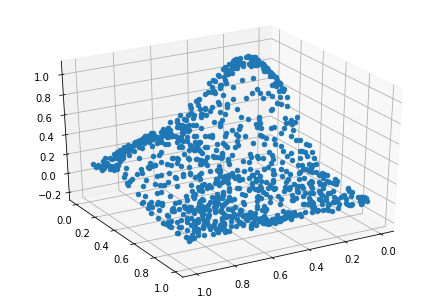

In [4]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(vert[:,0],vert[:,1],vert[:,2], depthshade=False)
ax.view_init(30, 60)
plt.show()

In [5]:
grid = Grid(minAxes, maxAxes, 10, 10)

wls = WLS(grid, 0.1)
wls.fit(vert)

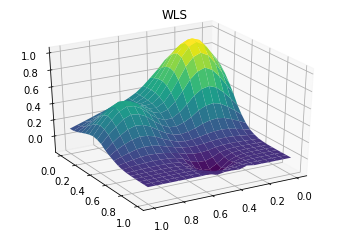

In [6]:
fig = plt.figure()

X = np.linspace(minAxes[0], maxAxes[0], 20)
Y = np.linspace(minAxes[1], maxAxes[1], 20)
X, Y = np.meshgrid(X, Y)

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title("WLS")
Z = wls.f(X, Y)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.view_init(30, 60)
plt.show()